In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import os
import zipfile
import matplotlib.pyplot as plt
import shutil
import opendatasets as od
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow import keras

In [6]:
od.download( 
    "https://www.kaggle.com/datasets/shubhamgoel27/dermnet")

Skipping, found downloaded files in ".\dermnet" (use force=True to force download)


In [10]:
traindir_path = ['dermnet/train/Acne and Rosacea Photos', 'dermnet/train/Bullous Disease Photos', 'dermnet/train/Exanthems and Drug Eruptions',
            'dermnet/train/Hair Loss Photos Alopecia and other Hair Diseases', 'dermnet/train/Herpes HPV and other STDs Photos',
            'dermnet/train/Melanoma Skin Cancer Nevi and Moles', 'dermnet/train/Psoriasis pictures Lichen Planus and related diseases',
            'dermnet/train/Systemic Disease', 'dermnet/train/Vascular Tumors']

# Check if the file exists before attempting to delete it
for path in traindir_path:
  if os.path.exists(path):
      shutil.rmtree(path)
      print(f"The file {path} has been deleted.")
  else:
      print(f"The file {path} does not exist.")

The file dermnet/train/Acne and Rosacea Photos has been deleted.
The file dermnet/train/Bullous Disease Photos has been deleted.
The file dermnet/train/Exanthems and Drug Eruptions has been deleted.
The file dermnet/train/Hair Loss Photos Alopecia and other Hair Diseases has been deleted.
The file dermnet/train/Herpes HPV and other STDs Photos has been deleted.
The file dermnet/train/Melanoma Skin Cancer Nevi and Moles has been deleted.
The file dermnet/train/Psoriasis pictures Lichen Planus and related diseases has been deleted.
The file dermnet/train/Systemic Disease has been deleted.
The file dermnet/train/Vascular Tumors has been deleted.


In [11]:
testdir_path = ['dermnet/test/Acne and Rosacea Photos', 'dermnet/test/Bullous Disease Photos', 'dermnet/test/Exanthems and Drug Eruptions',
            'dermnet/test/Hair Loss Photos Alopecia and other Hair Diseases', 'dermnet/test/Herpes HPV and other STDs Photos',
            'dermnet/test/Melanoma Skin Cancer Nevi and Moles', 'dermnet/test/Psoriasis pictures Lichen Planus and related diseases',
            'dermnet/test/Systemic Disease', 'dermnet/test/Vascular Tumors']

# Check if the file exists before attempting to delete it
for path in testdir_path:
  if os.path.exists(path):
      shutil.rmtree(path)
      print(f"The file {path} has been deleted.")
  else:
      print(f"The file {path} does not exist.")

The file dermnet/test/Acne and Rosacea Photos has been deleted.
The file dermnet/test/Bullous Disease Photos has been deleted.
The file dermnet/test/Exanthems and Drug Eruptions has been deleted.
The file dermnet/test/Hair Loss Photos Alopecia and other Hair Diseases has been deleted.
The file dermnet/test/Herpes HPV and other STDs Photos has been deleted.
The file dermnet/test/Melanoma Skin Cancer Nevi and Moles has been deleted.
The file dermnet/test/Psoriasis pictures Lichen Planus and related diseases has been deleted.
The file dermnet/test/Systemic Disease has been deleted.
The file dermnet/test/Vascular Tumors has been deleted.


In [16]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=128,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      shuffle=True)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator

In [17]:
# Define the training and validation base directories
TRAINING_DIR='dermnet/train'
VALIDATION_DIR='dermnet/test'

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 10265 images belonging to 14 classes.
Found 2573 images belonging to 14 classes.


### **CALLBACK**

In [22]:
# Define a Callback class that stops training once accuracy reaches 95.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.95 and logs.get('val_accuracy')>0.95):
      print("\nReached 95.0% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks=myCallback()

### **SIMPLE CNN**

In [24]:
##SIMPLE CNN
from keras.optimizers import Adam

def create_model():
  '''Creates a CNN with 4 convolutional layers'''
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(14, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['accuracy'])

  return model

In [25]:
# Constant for epochs
EPOCHS = 60

# Create a new model
model = create_model()

# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=40,  # 2000 images = batch_size * steps
                    epochs=EPOCHS,
                    validation_data=validation_generator,
                    validation_steps=40,  # 1000 images = batch_size * steps
                    verbose=2,
                    callbacks=[callbacks]
      )

Epoch 1/60
40/40 - 273s - loss: 2.4645 - accuracy: 0.1599 - val_loss: 2.3830 - val_accuracy: 0.2277 - 273s/epoch - 7s/step
Epoch 2/60
40/40 - 273s - loss: 2.3869 - accuracy: 0.2102 - val_loss: 2.3134 - val_accuracy: 0.2277 - 273s/epoch - 7s/step
Epoch 3/60
40/40 - 269s - loss: 2.3385 - accuracy: 0.2307 - val_loss: 2.3063 - val_accuracy: 0.2332 - 269s/epoch - 7s/step
Epoch 4/60
40/40 - 254s - loss: 2.3031 - accuracy: 0.2434 - val_loss: 2.2915 - val_accuracy: 0.2207 - 254s/epoch - 6s/step
Epoch 5/60
40/40 - 248s - loss: 2.2802 - accuracy: 0.2482 - val_loss: 2.2619 - val_accuracy: 0.2465 - 248s/epoch - 6s/step
Epoch 6/60
40/40 - 219s - loss: 2.2582 - accuracy: 0.2537 - val_loss: 2.2550 - val_accuracy: 0.2535 - 219s/epoch - 5s/step
Epoch 7/60
40/40 - 191s - loss: 2.2468 - accuracy: 0.2695 - val_loss: 2.2391 - val_accuracy: 0.2562 - 191s/epoch - 5s/step
Epoch 8/60
40/40 - 186s - loss: 2.2233 - accuracy: 0.2729 - val_loss: 2.2338 - val_accuracy: 0.2648 - 186s/epoch - 5s/step
Epoch 9/60
40/40

In [26]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

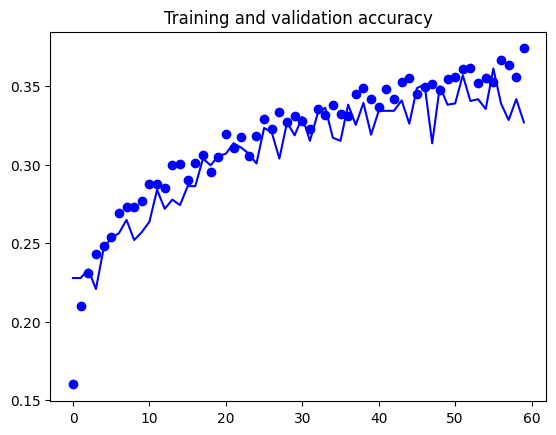

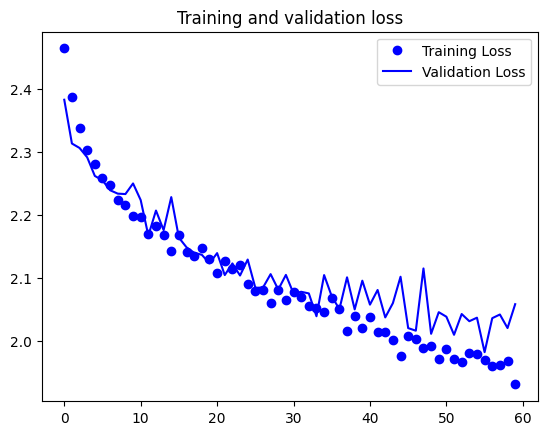

In [27]:
# Plot training results
plot_loss_acc(history)

### **FOR WHAT?**

In [ ]:
#FOR WHAT?
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_dataset = image_dataset_from_directory(TRAINING_DIR,
                                             shuffle=True,
                                             batch_size=256,
                                             image_size=(224,224))

Found 10265 files belonging to 14 classes.


In [ ]:
#FOR WHAT?
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dataset = image_dataset_from_directory(VALIDATION_DIR,
                                             shuffle=True,
                                             batch_size=64,
                                             image_size=(224,224))

Found 2573 files belonging to 14 classes.


In [ ]:
#FOR WHAT?
class_names = train_dataset.class_names

print(class_names)

['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [ ]:
def get_label_from_path(path):
  """Returns the class or directory name from a path."""
  return os.path.basename(path)

path = ['/content/train/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', '/content/train/Atopic Dermatitis Photos',
        '/content/train/Cellulitis Impetigo and other Bacterial Infections', '/content/train/Eczema Photos',
        '/content/train/Light Diseases and Disorders of Pigmentation', '/content/train/Lupus and other Connective Tissue diseases',
        '/content/train/Lupus and other Connective Tissue diseases', '/content/train/Nail Fungus and other Nail Disease',
        '/content/train/Poison Ivy Photos and other Contact Dermatitis', '/content/train/Scabies Lyme Disease and other Infestations and Bites',
        '/content/train/Seborrheic Keratoses and other Benign Tumors', '/content/train/Tinea Ringworm Candidiasis and other Fungal Infections',
        '/content/train/Urticaria Hives', '/content/train/Vasculitis Photos', '/content/train/Warts Molluscum and other Viral Infections']

for x in path:
  train_label = get_label_from_path(x)
  print(train_label)  # Output: "class_directory"


Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
Atopic Dermatitis Photos
Cellulitis Impetigo and other Bacterial Infections
Eczema Photos
Light Diseases and Disorders of Pigmentation
Lupus and other Connective Tissue diseases
Lupus and other Connective Tissue diseases
Nail Fungus and other Nail Disease
Poison Ivy Photos and other Contact Dermatitis
Scabies Lyme Disease and other Infestations and Bites
Seborrheic Keratoses and other Benign Tumors
Tinea Ringworm Candidiasis and other Fungal Infections
Urticaria Hives
Vasculitis Photos
Warts Molluscum and other Viral Infections


### **EFFICIENTNETB0**

In [ ]:
from keras.applications import EfficientNetB0

pre_trained_model = EfficientNetB0(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1

In [ ]:
# Choose `block5c_add` as the last layer of your base model
last_layer = pre_trained_model.get_layer('block5c_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 112)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(14, activation='softmax')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Train the model.
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 40,
            epochs = 50,
            verbose = 2,
            callbacks = [callbacks])

Epoch 1/50
40/40 - 87s - loss: 2.5938 - accuracy: 0.1258 - val_loss: 2.5882 - val_accuracy: 0.1263 - 87s/epoch - 2s/step
Epoch 2/50
40/40 - 23s - loss: 2.5792 - accuracy: 0.1273 - val_loss: 2.5750 - val_accuracy: 0.1263 - 23s/epoch - 569ms/step
Epoch 3/50
40/40 - 23s - loss: 2.5668 - accuracy: 0.1277 - val_loss: 2.5632 - val_accuracy: 0.1263 - 23s/epoch - 567ms/step
Epoch 4/50
40/40 - 22s - loss: 2.5512 - accuracy: 0.1355 - val_loss: 2.5527 - val_accuracy: 0.1333 - 22s/epoch - 552ms/step
Epoch 5/50
40/40 - 32s - loss: 2.5500 - accuracy: 0.1207 - val_loss: 2.5439 - val_accuracy: 0.1333 - 32s/epoch - 791ms/step
Epoch 6/50
40/40 - 31s - loss: 2.5387 - accuracy: 0.1391 - val_loss: 2.5359 - val_accuracy: 0.1333 - 31s/epoch - 783ms/step
Epoch 7/50
40/40 - 23s - loss: 2.5294 - accuracy: 0.1391 - val_loss: 2.5288 - val_accuracy: 0.1333 - 23s/epoch - 571ms/step
Epoch 8/50
40/40 - 23s - loss: 2.5199 - accuracy: 0.1270 - val_loss: 2.5224 - val_accuracy: 0.1333 - 23s/epoch - 567ms/step
Epoch 9/50


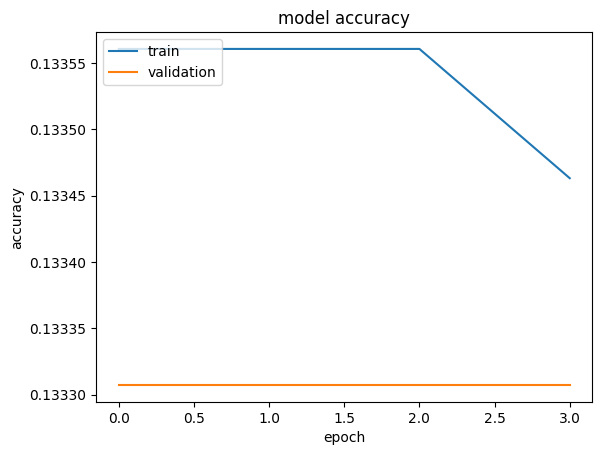

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

Epoch 1/4
161/161 [==============================] - 65s 364ms/step - loss: 2.4731 - accuracy: 0.1336 - val_loss: 2.4739 - val_accuracy: 0.1333
Epoch 2/4
161/161 [==============================] - 65s 405ms/step - loss: 2.4731 - accuracy: 0.1336 - val_loss: 2.4739 - val_accuracy: 0.1333
Epoch 3/4
161/161 [==============================] - 57s 356ms/step - loss: 2.4731 - accuracy: 0.1336 - val_loss: 2.4739 - val_accuracy: 0.1333
Epoch 4/4
161/161 [==============================] - 57s 354ms/step - loss: 2.4731 - accuracy: 0.1336 - val_loss: 2.4739 - val_accuracy: 0.1333


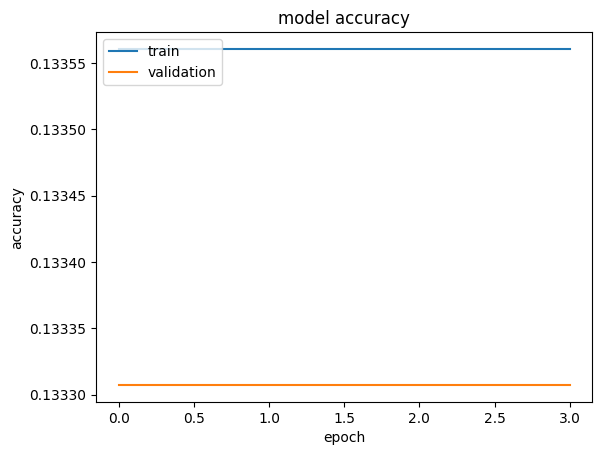

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)
plot_hist(hist)

### **UNET**

In [ ]:
# Preprocessing Utilities

def random_flip(input_image, input_mask):
  '''does a random flip of the image and mask'''
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  return input_image, input_mask


def normalize(input_image, input_mask):
  '''
  normalizes the input image pixel values to be from [0,1].
  subtracts 1 from the mask labels to have a range from [0,2]
  '''
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask


@tf.function
def load_image_train(datapoint):
  '''resizes, normalizes, and flips the training data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = random_flip(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  
  return input_image, input_mask


def load_image_test(datapoint):
  '''resizes and normalizes the test data'''
  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
# preprocess the train and test sets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# shuffle and group the train set into batches
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# group the test set into batches
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''
  
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 


def display(display_list,titles=[], display_string=None):
  '''displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()


def show_image_from_dataset(dataset):
  '''displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [ ]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

In [ ]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    pool_size (int, int) -- size of the pooling layer
    dropout (float) -- between 0 and 1. rate of the dropout layer

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [ ]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    dropout (float) -- between 0 and 1. rate of the dropout layer

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

In [ ]:
OUTPUT_CHANNELS = 3

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
model = unet()

# see the resulting model architecture
model.summary()

In [ ]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# configure the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

In [ ]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

In [ ]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''

  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)
  
  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()
  
  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  
  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))], y_true_segments


def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask 

In [ ]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):
    
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [ ]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

In [ ]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [ ]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 

In [ ]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 


In [ ]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)  

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)

### **SAVE MODEL**

In [1]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('Simple_CNNriil.h5')

# Access weights of each layer
for layer in model.layers:
  weights = layer.get_weights()  # List of weight tensors for the layer
  # You can further process or analyze the weights here

In [4]:
from tensorflow.keras.models import load_model

try:
  model = load_model('Simple_CNNriil.h5')
  print("Model loaded successfully!")
except OSError as e:
  print("Error loading model:", e)
except ValueError as e:
  print("Error in model file:", e)

Model loaded successfully!


In [2]:
model.save("Simple_CNN2.h5")

In [39]:
model.save_pretrained(save_directory = "dermnet", safe_serialization=False)

AttributeError: 'Sequential' object has no attribute 'save_pretrained'

In [37]:
model_json = model.to_json()
with open("Simple_CNN.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("Simple_CNN.bin")
print("Saved model .......")

Saved model .......


In [34]:
# import time
!tensorflowjs_converter \
    --input_format=keras Simple_CNN.h5 ./
# !tensorflowjs_converter --input_format=keras dummymodel.h5 dummymodel.json

Traceback (most recent call last):
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\Clara Carissa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflowjs\converters\converter.py", line 29, in <modul

In [ ]:
model_save_path = "./tmp/dummymodel.h5"
modelin.save(model_save_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
files.download('/content/tmp/dummymodel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install tensorflowjs

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!zip dummypol.zip *.bin modelin.json

	zip warning: name not matched: *.bin
	zip warning: name not matched: modelin.json

zip error: Nothing to do! (dummypol.zip)
